***Задание 1***: Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [130]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [131]:
from sklearn.datasets import load_diabetes

In [132]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [133]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем класс, реализующий предсказание в градиентном бустинге.

In [154]:
class GBoostClassifier:
    def __init__(
        self,
        n_trees: int = 3,
        max_depth: int = 3,
        coefs: list =  [1] * 3,
        eta: float = 0.1):
        
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        
    def fit(self, X_train, X_test, y_train, y_test):
        self = self.gb_fit(X_train, X_test, y_train, y_test)
        return self
    
    def predict(self, X: np.array):
        return self.gb_predict(X)
    
    def gb_fit(self, X_train, X_test, y_train, y_test):
    
        # Деревья будем записывать в список
        self.trees = []

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        self.train_errors = []
        self.test_errors = []

        for i in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)

                self.train_errors.append(self.mean_squared_error(y_train, self.gb_predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.gb_predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                target = self.gb_predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train, target))

                self.train_errors.append(self.mean_squared_error(y_train, self.gb_predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.gb_predict(X_test)))

            self.trees.append(tree)

        return self
    
    def gb_predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])
    
    def evaluate_alg(self, X_train, X_test, y_train, y_test):
        train_prediction = self.gb_predict(X_train)

        print(f'GBC: Ошибка алгоритма из {self.n_trees} деревьев глубиной {self.max_depth} \
        с шагом {self.eta} на тренировочной выборке: {self.mean_squared_error(y_train, train_prediction)}')

        test_prediction = self.gb_predict(X_test)

        print(f'GBC: Ошибка алгоритма из {self.n_trees} деревьев глубиной {self.max_depth} \
        с шагом {self.eta} на тестовой выборке: {self.mean_squared_error(y_test, test_prediction)}')
        
    
    @staticmethod
    def mean_squared_error(y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    @staticmethod
    def bias(y, z):
        return (y - z)

In [164]:
# Число деревьев в ансамбле
n_trees = 3

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

GBC = GBoostClassifier(n_trees, max_depth, coefs, eta)
GBC.fit(X_train, X_test, y_train, y_test)
GBC.evaluate_alg(X_train, X_test, y_train, y_test)


GBC: Ошибка алгоритма из 3 деревьев глубиной 3         с шагом 0.1 на тренировочной выборке: 16873.087856718754
GBC: Ошибка алгоритма из 3 деревьев глубиной 3         с шагом 0.1 на тестовой выборке: 16678.43707210588


In [165]:
class GBoostErrPlot:
    def __init__(
        self,
        max_n_trees: int = 10,
        max_depth: int = 10,
        coefs: list =  [1] * 3,
        eta: float = 0.1):
        
        self.max_n_trees = max_n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.all_train_errors = []
        self.all_test_errors = []
        
    def fit(self, X_train, X_test, y_train, y_test):
        for max_depth in range(1, self.max_depth):
            GBC = GBoostClassifier(self.max_n_trees, max_depth, self.coefs, self.eta)
            GBC.fit(X_train, X_test, y_train, y_test)
            self.all_train_errors.append(GBC.train_errors)
            self.all_test_errors.append(GBC.test_errors)
        return self
    
    def get_plot_n_trees(self, n_depth):
        plt.suptitle(f'Глубина равна {n_depth}')
        plt.xlabel('Number of trees')
        plt.ylabel('MSE')
        plt.xlim(1, self.max_n_trees+1)
        plt.plot(list(range(1, self.max_n_trees+1)), self.all_train_errors[n_depth-1], label='train error')
        plt.plot(list(range(1, self.max_n_trees+1)), self.all_test_errors[n_depth-1], label='test error')
        plt.legend(loc='upper right')
        plt.show()
    
    def get_plot_max_depth(self, n_trees):
        plt.suptitle(f'Количество деревьев равно {n_trees}')
        plt.xlabel('Depth of trees')
        plt.ylabel('MSE')
        plt.xlim(1, self.max_depth)
        plt.plot(list(range(1, self.max_depth)), list(zip(*self.all_train_errors))[n_trees-1], label='train error')
        plt.plot(list(range(1, self.max_depth)), list(zip(*self.all_test_errors))[n_trees-1], label='test error')
        plt.legend(loc='upper right')
        plt.show()
        

In [166]:
GBPlot = GBoostErrPlot(50, 10, coefs, eta)
GBPlot.fit(X_train, X_test, y_train, y_test)

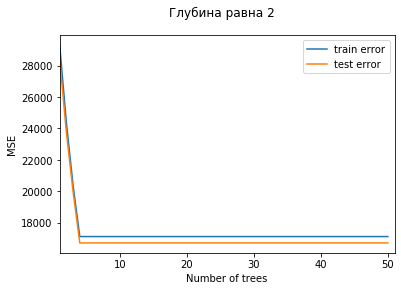

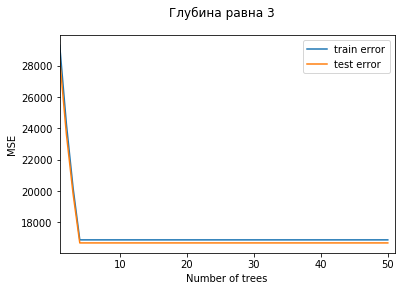

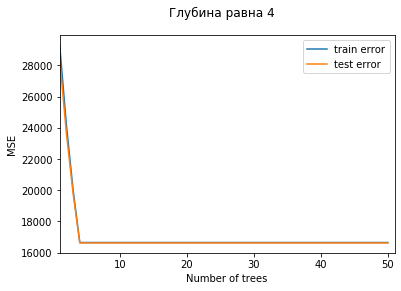

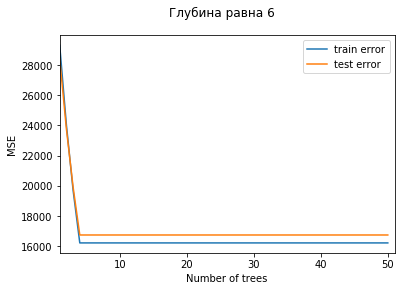

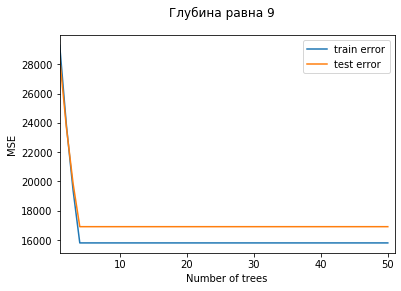

In [167]:
### график ошибки в зависимости от количества деревьев при разных значениях максимальной глубины
for n_depth in [2,3,4,6,9]:
    GBPlot.get_plot_n_trees(n_depth)

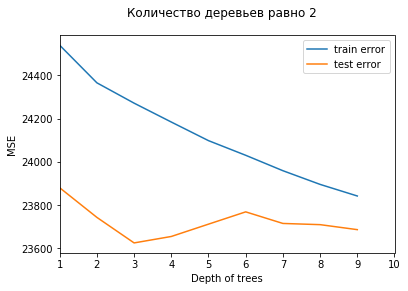

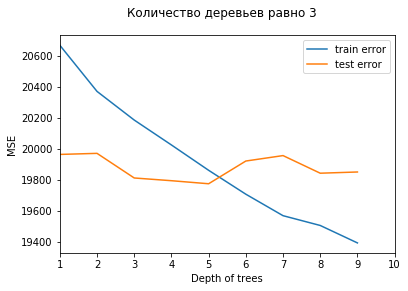

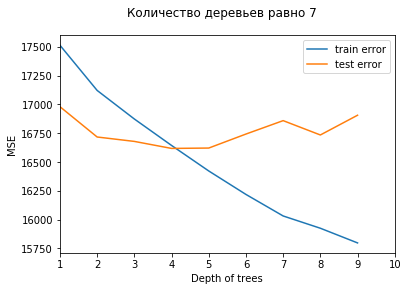

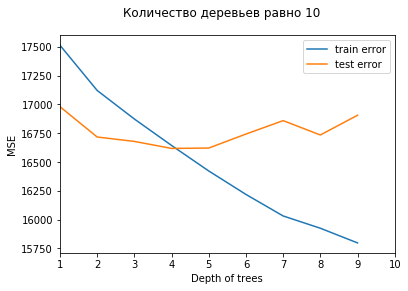

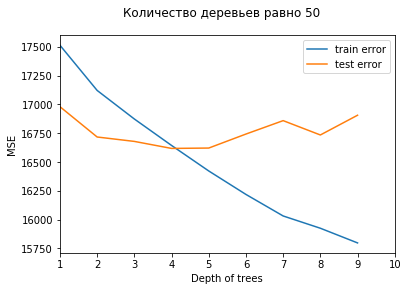

In [175]:
### график ошибки в зависимости от глубины дерева при разных значениях количества деревьев
for n_tree in [2,3,7,10,50]:
    GBPlot.get_plot_max_depth(n_tree)

***Вывод:*** При увеличении количества деревьев и глубины дерева наступает переобучение (ошибка на train продолжает падать, а на test расти). При этом для количества деревьев более 6 (и eta = 0.1) оптимальная глубина равна 4. Но при этом ошибка остается еще очень большой и нужно подбирать другие параметры

***Задание 2: (опция).*** Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [169]:
class SGBoostClassifier:
    def __init__(
        self,
        n_trees: int = 3,
        max_depth: int = 3,
        coefs: list =  [1] * 3,
        eta: float = 0.1,
        n_sample: float = 0.5):
        
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.n_sample = n_sample
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        
    def fit(self, X_train, X_test, y_train, y_test):
        self = self.gb_fit(X_train, X_test, y_train, y_test)
        return self
    
    def predict(self, X: np.array):
        return self.gb_predict(X)
    
    def gb_fit(self, X_train, X_test, y_train, y_test):
    
        # Деревья будем записывать в список
        self.trees = []

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        self.train_errors = []
        self.test_errors = []

        for i in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)

                self.train_errors.append(self.mean_squared_error(y_train, self.gb_predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.gb_predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                target = self.gb_predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                sample_index = np.random.randint(low=0, high=len(X_train), size=(int(self.n_sample*len(X_train))+1,))
                tree.fit(X_train[sample_index, :], self.bias(y_train[sample_index], target[sample_index]))

                self.train_errors.append(self.mean_squared_error(y_train, self.gb_predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.gb_predict(X_test)))

            self.trees.append(tree)

        return self
    
    def gb_predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])
    
    def evaluate_alg(self, X_train, X_test, y_train, y_test):
        train_prediction = self.gb_predict(X_train)

        print(f'Ошибка алгоритма из {self.n_trees} деревьев глубиной {self.max_depth} \
        с шагом {self.eta} на тренировочной выборке: {self.mean_squared_error(y_train, train_prediction)}')

        test_prediction = self.gb_predict(X_test)

        print(f'Ошибка алгоритма из {self.n_trees} деревьев глубиной {self.max_depth} \
        с шагом {self.eta} на тестовой выборке: {self.mean_squared_error(y_test, test_prediction)}')
        
    
    @staticmethod
    def mean_squared_error(y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    @staticmethod
    def bias(y, z):
        return (y - z)

In [170]:
# Число деревьев в ансамбле
n_trees = 3

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

# Размер подвыборки
n_sample = 0.5

SGBC = SGBoostClassifier(n_trees, max_depth, coefs, eta, n_sample)
SGBC.fit(X_train, X_test, y_train, y_test)
SGBC.evaluate_alg(X_train, X_test, y_train, y_test)

Ошибка алгоритма из 3 деревьев глубиной 3         с шагом 0.1 на тренировочной выборке: 17087.987825459186
Ошибка алгоритма из 3 деревьев глубиной 3         с шагом 0.1 на тестовой выборке: 16863.770144400456


In [171]:
class SGBoostErrPlot:
    def __init__(
        self,
        max_n_trees: int = 10,
        max_depth: int = 10,
        coefs: list =  [1] * 3,
        eta: float = 0.1,
        n_sample: float = 0.5):
        
        self.max_n_trees = max_n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.n_sample = n_sample
        self.all_train_errors = []
        self.all_test_errors = []
        
    def fit(self, X_train, X_test, y_train, y_test):
        for max_depth in range(1, self.max_depth):
            SGBC = SGBoostClassifier(self.max_n_trees, max_depth, self.coefs, self.eta, self.n_sample)
            SGBC.fit(X_train, X_test, y_train, y_test)
            self.all_train_errors.append(SGBC.train_errors)
            self.all_test_errors.append(SGBC.test_errors)
        return self
    
    def get_plot_n_trees(self, n_depth):
        plt.suptitle(f'Глубина равна {n_depth}')
        plt.xlabel('Number of trees')
        plt.ylabel('MSE')
        plt.xlim(1, self.max_n_trees+1)
        plt.plot(list(range(1, self.max_n_trees+1)), self.all_train_errors[n_depth-1], label='train error')
        plt.plot(list(range(1, self.max_n_trees+1)), self.all_test_errors[n_depth-1], label='test error')
        plt.legend(loc='upper right')
        plt.show()
    
    def get_plot_max_depth(self, n_trees):
        plt.suptitle(f'Количество деревьев равно {n_trees}')
        plt.xlabel('Depth of trees')
        plt.ylabel('MSE')
        plt.xlim(1, self.max_depth)
        plt.plot(list(range(1, self.max_depth)), list(zip(*self.all_train_errors))[n_trees-1], label='train error')
        plt.plot(list(range(1, self.max_depth)), list(zip(*self.all_test_errors))[n_trees-1], label='test error')
        plt.legend(loc='upper right')
        plt.show()

In [172]:
SGBPlot = SGBoostErrPlot(20, 10, coefs, eta)
SGBPlot.fit(X_train, X_test, y_train, y_test)

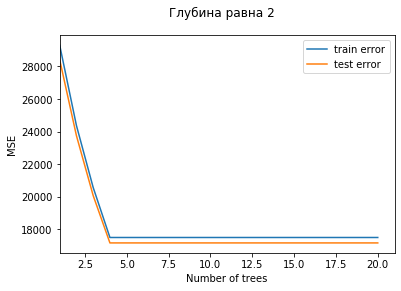

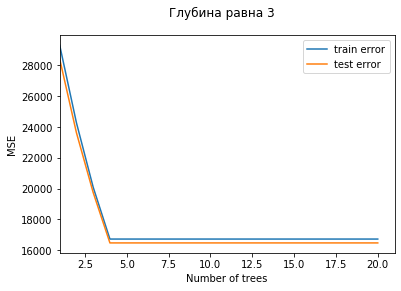

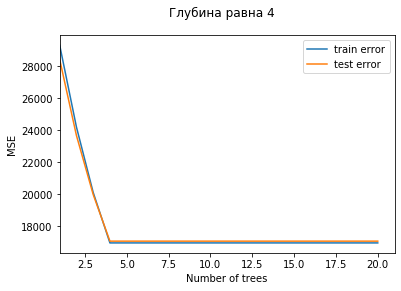

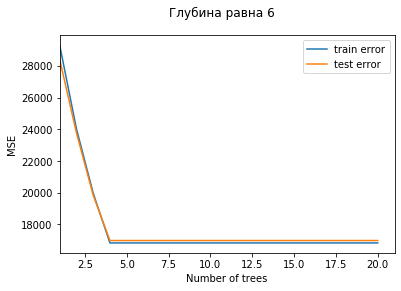

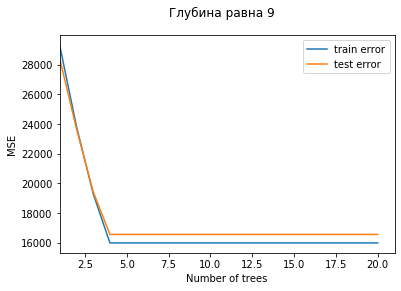

In [173]:
### график ошибки в зависимости от количества деревьев при разных значениях максимальной глубины
for n_depth in [2,3,4,6,9]:
    SGBPlot.get_plot_n_trees(n_depth)

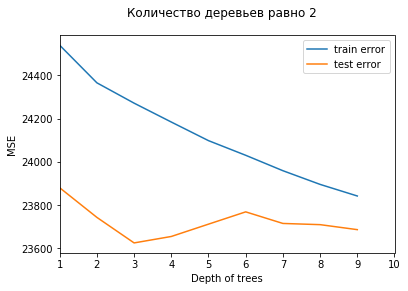

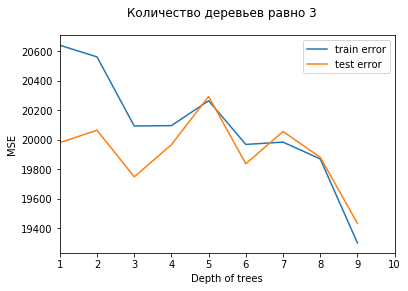

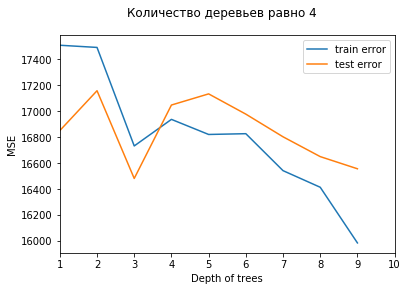

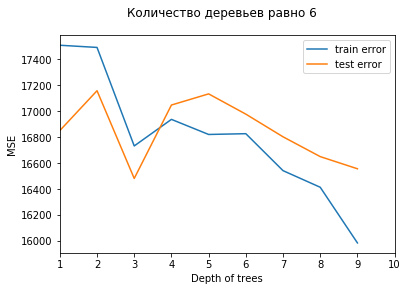

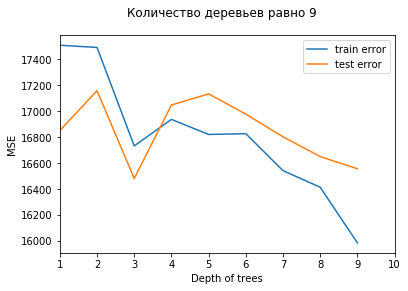

In [174]:
### график ошибки в зависимости от глубины дерева при разных значениях количества деревьев
for n_tree in [2,3,4,6,9]:
    SGBPlot.get_plot_max_depth(n_tree)

***Вывод.*** При стохачстическом методе графики ошибок становятся не такими плавными. Однако существенного улучшения результатов при данных параметрах не происходит

***Задание 3: (опция).*** Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [1]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [2]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [150]:
class OurDecisionTreeRegressor:
    def __init__(
        self, 
        max_depth: int = 0, 
        max_features: int = 0, 
        max_leaves: int = 0, 
        cr_type : str = 'gini'):
        
        self.max_depth = max_depth
        self.max_features = max_features
        self.max_leaves = max_leaves
        self.cr_type = cr_type
        self.cur_leaf = 0
        self.depth = 0
        self.cur_leaf = 0
        self.tree = None
        
    def fit(self, data, labels):
        
        self.tree = self.build_tree(data, labels, 0, 0)
        return self
    
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes
    
    
    def build_tree(self, data, labels, cur_depth, num_leaf):
        global cur_leaf
        cur_leaf = num_leaf


        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            cur_leaf += 1
            return Leaf(data, labels)

        #  Ограничение на глубину дерева
        if cur_depth >= self.max_depth:
            cur_leaf += 1
            return Leaf(data, labels)

        # Ограничение на количество листьев
        if self.cur_leaf + self.depth >= self.max_leaves:
            cur_leaf += 1
            return Leaf(data, labels)


        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        
        self.depth += 1
        self.cur_leaf += 2
        
        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, cur_depth + 1, cur_leaf)
        false_branch = self.build_tree(false_data, false_labels, cur_depth + 1, cur_leaf)
        

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
    
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_criter = self.criterion(labels, self.cr_type)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in np.random.choice(range(n_features), self.max_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criter)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    # Разбиение датасета в узле
    @staticmethod
    def split(data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Расчет качества
    def quality(self, left_labels, right_labels, current_criter):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_criter - p * self.criterion(left_labels, self.cr_type) - \
                (1 - p) * self.criterion(right_labels, self.cr_type)
    
    # Расчет критерия Джини или Энтропии
    @staticmethod
    def criterion(labels, cr_type):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        if cr_type == 'gini':
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2
        else:
            impurity = 0
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p * math.log(p, 2)

        return impurity
    
    # классификация объектов
    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
     

In [156]:
class OurGBoostClassifier:
    def __init__(
        self,
        n_trees: int = 3,
        max_depth: int = 3,
        coefs: list =  [1] * 3,
        eta: float = 0.1):
        
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        
    def fit(self, X_train, X_test, y_train, y_test):
        self = self.gb_fit(X_train, X_test, y_train, y_test)
        return self
    
    def predict(self, X: np.array):
        return self.gb_predict(X)
    
    def gb_fit(self, X_train, X_test, y_train, y_test):
    
        # Деревья будем записывать в список
        self.trees = []

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        self.train_errors = []
        self.test_errors = []

        for i in range(self.n_trees):
            tree = OurDecisionTreeRegressor(max_depth=self.max_depth, max_features = 2, max_leaves = 100, cr_type = 'gini')

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)

                self.train_errors.append(self.mean_squared_error(y_train, self.gb_predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.gb_predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                target = self.gb_predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train, target))

                self.train_errors.append(self.mean_squared_error(y_train, self.gb_predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.gb_predict(X_test)))

            self.trees.append(tree)

        return self
    
    def gb_predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])
    
    def evaluate_alg(self, X_train, X_test, y_train, y_test):
        train_prediction = self.gb_predict(X_train)

        print(f'OurGBC: Ошибка алгоритма из {self.n_trees} деревьев глубиной {self.max_depth} \
        с шагом {self.eta} на тренировочной выборке: {self.mean_squared_error(y_train, train_prediction)}')

        test_prediction = self.gb_predict(X_test)

        print(f'OurGBC: Ошибка алгоритма из {self.n_trees} деревьев глубиной {self.max_depth} \
        с шагом {self.eta} на тестовой выборке: {self.mean_squared_error(y_test, test_prediction)}')
        
    
    @staticmethod
    def mean_squared_error(y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    @staticmethod
    def bias(y, z):
        return (y - z)

In [157]:
# Число деревьев в ансамбле
n_trees = 3

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

GBC = GBoostClassifier(n_trees, max_depth, coefs, eta)
GBC.fit(X_train, X_test, y_train, y_test)
GBC.evaluate_alg(X_train, X_test, y_train, y_test)

OurGBC = OurGBoostClassifier(n_trees, max_depth, coefs, eta)
OurGBC.fit(X_train, X_test, y_train, y_test)
OurGBC.evaluate_alg(X_train, X_test, y_train, y_test)


GBC: Ошибка алгоритма из 3 деревьев глубиной 3         с шагом 0.1 на тренировочной выборке: 16873.087856718754
GBC: Ошибка алгоритма из 3 деревьев глубиной 3         с шагом 0.1 на тестовой выборке: 16678.43707210588
OurGBC: Ошибка алгоритма из 3 деревьев глубиной 3         с шагом 0.1 на тренировочной выборке: 15453.733295797585
OurGBC: Ошибка алгоритма из 3 деревьев глубиной 3         с шагом 0.1 на тестовой выборке: 14620.674675360355


In [163]:
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 4

# Шаг
eta = 0.01

GBC = GBoostClassifier(n_trees, max_depth, coefs, eta)
GBC.fit(X_train, X_test, y_train, y_test)
GBC.evaluate_alg(X_train, X_test, y_train, y_test)

OurGBC = OurGBoostClassifier(n_trees, max_depth, coefs, eta)
OurGBC.fit(X_train, X_test, y_train, y_test)
OurGBC.evaluate_alg(X_train, X_test, y_train, y_test)

GBC: Ошибка алгоритма из 100 деревьев глубиной 4         с шагом 0.01 на тренировочной выборке: 5629.685256367783
GBC: Ошибка алгоритма из 100 деревьев глубиной 4         с шагом 0.01 на тестовой выборке: 6587.637757280394
OurGBC: Ошибка алгоритма из 100 деревьев глубиной 4         с шагом 0.01 на тренировочной выборке: 6521.472479628888
OurGBC: Ошибка алгоритма из 100 деревьев глубиной 4         с шагом 0.01 на тестовой выборке: 6228.6557724289305


In [160]:
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 4

# Шаг
eta = 0.1

GBC = GBoostClassifier(n_trees, max_depth, coefs, eta)
GBC.fit(X_train, X_test, y_train, y_test)
GBC.evaluate_alg(X_train, X_test, y_train, y_test)

OurGBC = OurGBoostClassifier(n_trees, max_depth, coefs, eta)
OurGBC.fit(X_train, X_test, y_train, y_test)
OurGBC.evaluate_alg(X_train, X_test, y_train, y_test)

GBC: Ошибка алгоритма из 100 деревьев глубиной 4         с шагом 0.1 на тренировочной выборке: 370.1720533138147
GBC: Ошибка алгоритма из 100 деревьев глубиной 4         с шагом 0.1 на тестовой выборке: 3344.245638976175
OurGBC: Ошибка алгоритма из 100 деревьев глубиной 4         с шагом 0.1 на тренировочной выборке: 3240.465800308845
OurGBC: Ошибка алгоритма из 100 деревьев глубиной 4         с шагом 0.1 на тестовой выборке: 3590.0225788946673


***Вывод.*** На трех деревьях глубины 3 и eta = 0.1, а также на 100 деревьях и eta = 0.01 получилось даже, что самописный алгоритм дерева работает лучше, правда при 100 деревьях и eta = 0.1 он показывает худшие результаты. Однако маленькой величины ошибки на тестовой выборке так и не удалось добиться ни одним из алгоритомов.